In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import Input, Sequential
from tensorflow.python.keras.engine.functional import Functional
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.models import Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from tensorflow.keras.layers import (Dense, Lambda, Conv2D, Conv2DTranspose, LeakyReLU, 
                                    BatchNormalization,UpSampling2D, ZeroPadding2D, Activation ,Flatten, Reshape, Cropping2D, Dropout)
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.constraints import MinMaxNorm

from tensorflow.keras import backend as K

import glob
import imageio
import os
import PIL
import time

from IPython import display
from tensorflow.keras.optimizers import Adam, RMSprop

import tensorflow_docs.vis.embed as embed

## Load the Polynomial dataset, display an image and save it.

In [ ]:
#load the dataset
polydata = np.load('./dataset/polydata.npy')

#plot and save an image from the dataset
plt.imshow(polydata[1])
dir = os.path.join("images")
if not os.path.exists(dir):
    os.mkdir(dir)
dir2 = os.path.join("./images/DCGAN")
if not os.path.exists(dir2):
    os.mkdir(dir2)
plt.savefig('./images/DCGAN/contour.png')

# Deep Convolutional Generative Adversarial Network with Keras

The aim of this program is to implement a DCGAN architecture and to test it on the Polynomial dataset.

Code partially adapted on the new Polynomial dataset from the [GitHub Repository](https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py).

In [5]:
class DCGAN():
    def __init__(self, data):

        self.x_train = data
        self.channels = 1
        self.img_shape =(self.x_train.shape[1], 
                         self.x_train.shape[2], 
                         self.channels)
        self.latent_dim = 2
        self.noise = Input(shape=(self.latent_dim,))

        self.generator = None
        self.generator_model = None

        self.discriminator = None
        self.discriminator_model = None

        self.valid = None
        self.loss_record = np.array([None, None])

       
    
    def build_generator_model(self):


        self.generator = Sequential(
            [
                self.noise,
                Dense(128 * 10 * 10, use_bias=False),
                BatchNormalization(momentum=0.8),
                LeakyReLU(alpha=0.2),
                Reshape((10, 10, 128)),
                UpSampling2D(),

                Conv2DTranspose(128, kernel_size=3, padding='same', use_bias=False),
                BatchNormalization(momentum=0.8),
                LeakyReLU(alpha=0.2),
                UpSampling2D(),
        
                Conv2DTranspose(64, kernel_size=3, padding='same', use_bias=False),
                BatchNormalization(momentum=0.8),
                LeakyReLU(alpha=0.2),

                Conv2DTranspose(self.channels, kernel_size=3, padding='same', use_bias=False),
                Activation("tanh"),
            ],
            name="generator",
        )
        self.generator.summary()
        self.generator_model = Model (self.noise, self.generator(self.noise) )
    
    def build_discriminator_model(self, optimizer = Adam(0.0002, 0.5)):

        img_shape = Input(shape = self.img_shape)
        self.discriminator = Sequential(
            [
                img_shape,
                Conv2D(16, kernel_size=3, strides=2, padding="same"),
                LeakyReLU(alpha=0.2),
                Dropout(0.25),

                Conv2D(32, kernel_size=3, strides=2, padding="same"),
                ZeroPadding2D(padding=((0,1),(0,1))),
                BatchNormalization(momentum=0.8),
                LeakyReLU(alpha=0.2),
                Dropout(0.25),

                Conv2D(64, kernel_size=3, strides=2, padding="same"),
                BatchNormalization(momentum=0.8),
                LeakyReLU(alpha=0.2),
                Dropout(0.25),

                Conv2D(128, kernel_size=3, strides=1, padding='same'),
                BatchNormalization(momentum=0.8),
                LeakyReLU(alpha=0.2),
                Dropout(0.25),
                Flatten(),
                Dense(self.channels),
                Activation('sigmoid'),
            ],
            name="discriminator"
        )
        self.discriminator.summary()
        self.discriminator_model = Model (img_shape, self.discriminator(img_shape) )
        self.discriminator_model.compile(loss='binary_crossentropy',
                                         optimizer = optimizer,
                                         metrics=['accuracy'])
        gen_imgs = self.generator_model(self.noise)
        self.discriminator_model.trainable = False

        self.valid = self.discriminator_model(gen_imgs)
        
    def combined_model(self, optimizer = Adam(0.0002, 0.5)):
            
        self.combined_model = Model (self.noise, self.valid)
        self.combined_model.compile(loss='binary_crossentropy',
                                       optimizer=optimizer,
                                       metrics=['accuracy'])


    def train(self, epochs, batch_size=128, save_interval=50):

        

        # Rescale -1 to 1
        self.x_train = np.expand_dims(self.x_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        start_loop = time.time()

        for epoch in range(epochs):

            # +---------------------+
            # | Train Discriminator |
            # +---------------------+

            # Select a random half of images
            idx = np.random.randint(0, self.x_train.shape[0], batch_size)
            imgs = self.x_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator_model.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator_model.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator_model.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # +-----------------+
            # | Train Generator |
            # +-----------------+

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined_model.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch+1, d_loss[0], 100*d_loss[1], g_loss[0]))
            self.loss_record = np.vstack([self.loss_record, np.array([d_loss[0], g_loss[0]])])

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
        print("\nTotal time taken: %.2fs" % (time.time() - start_loop))
        print("\n\n\n")
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator_model.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./images/DCGAN/training_checkpoints/poly_%d.png" % epoch)
        plt.close()

    def fig(self):
        fig, axes = plt.subplots(2, 8, figsize=(19,5))
        for i in range(2):
            for j in range(8):
                out = self.generator_model.predict(np.reshape(np.random.normal(0,1,2),(1,2)))
                axes[i,j].imshow(out[0,:,:,0])
        fig.savefig("./images/DCGAN/generated.png")

        fig, axes = plt.subplots(2, 8, figsize=(19,5))
        for i in range(2):
            for j in range(8):
                axes[i,j].imshow(polydata[i*j+j])
        fig.savefig("./images/DCGAN/original.png")
    
    def gif(self):
        """Creation of the gif with generated images over epochs."""

        with imageio.get_writer('./images/DCGAN/dcgan_poly.gif', mode='I') as writer:
            filenames = glob.glob('./images/DCGAN/training_checkpoints/poly*.png')
            filenames = sorted(filenames)
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)
            image = imageio.imread(filename)
            writer.append_data(image)
            embed.embed_file('./images/DCGAN/dcgan_poly.gif')


    
    def plot_losses(self):
        """Plotting the Generator and Discriminator losses"""
        fig = plt.figure(figsize=(5, 5))
        plt.plot(self.loss_record[:])
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Generator Loss', 'Discriminator Loss'], loc='best')
        plt.title('Generator and Discriminator losses')
        plt.savefig('./images/DCGAN/g_d_losses.png')

        plt.show()

    def dir(self):
        """Creation of the folders path to store the results."""
        dir = os.path.join("images")
        if not os.path.exists(dir):
            os.mkdir(dir)
        dir2 = os.path.join("./images/DCGAN")
        if not os.path.exists(dir2):
            os.mkdir(dir2)
        dir3 = os.path.join("./images/DCGAN/training_checkpoints")
        if not os.path.exists(dir3):
            os.mkdir(dir3)

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12800)             25600     
_________________________________________________________________
batch_normalization (BatchNo (None, 12800)             51200     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12800)             0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 20, 20, 128)       147456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 128)       51

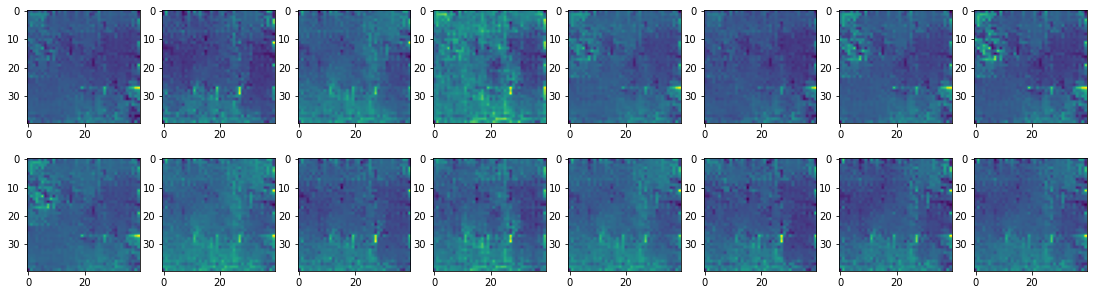

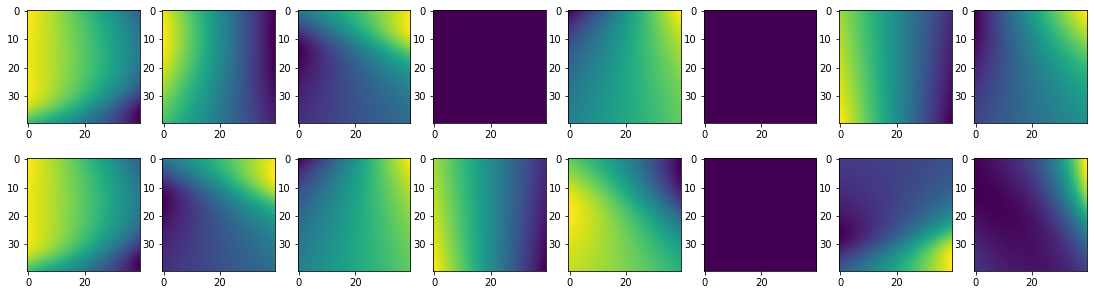

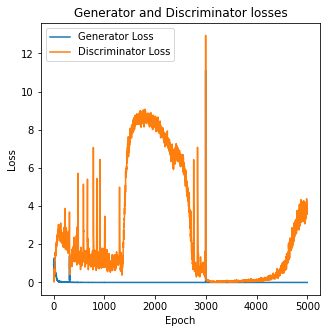

In [6]:
dcgan=DCGAN(polydata)
dcgan.build_generator_model()
dcgan.build_discriminator_model()
dcgan.combined_model()
dcgan.dir()
dcgan.train(epochs=5000, save_interval=250)
dcgan.fig()
dcgan.plot_losses()
dcgan.gif()
